# Correlation Analysis: Skills, Experience & Salary

## Research Questions
1. Which skills correlate most with higher salaries?
2. Which skills often appear together?
3. Is experience level the strongest salary predictor?

## Methods
- Pearson/Spearman correlation
- Partial correlation (controlling for experience)
- Correlation heatmaps

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'  
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import os

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✓ Imports complete')

✓ Imports complete


## 1. Load and Prepare Data

In [4]:
project_root = r'C:\Users\Eilhart\Documents\PythonScripts\data-analyst-job-market'
df = pd.read_csv(os.path.join(project_root, 'data', 'processed', 'jobs_with_work_type_v2.csv'), low_memory=False)

print(f"Total jobs: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")

Total jobs: 46,610

Columns: ['job_id', 'title', 'company_name', 'location', 'state', 'posted_date_clean', 'year', 'month', 'quarter', 'salary_min', 'salary_max', 'salary_avg', 'has_salary', 'experience_level', 'work_type', 'is_remote', 'skills_text', 'skills_count', 'software_text', 'software_count', 'description', 'source', 'url', 'skills_extracted_text', 'skills_extracted_count']


In [5]:
# Filter to jobs with salary data
df_salary = df[df['salary_avg'].notna()].copy()

print(f"Jobs with salary data: {len(df_salary):,} ({len(df_salary)/len(df)*100:.1f}%)")
print(f"\nSalary range: ${df_salary['salary_avg'].min():,.0f} - ${df_salary['salary_avg'].max():,.0f}")
print(f"Mean salary: ${df_salary['salary_avg'].mean():,.0f}")
print(f"Median salary: ${df_salary['salary_avg'].median():,.0f}")

Jobs with salary data: 11,706 (25.1%)

Salary range: $9 - $550,000
Mean salary: $74,851
Median salary: $80,000


In [6]:
# Check suspected hourly wages
hourly_suspected = df_salary[df_salary['salary_avg'] < 100]

print(f"Jobs with salary < $100: {len(hourly_suspected):,}")
print(f"\nSample values:")
print(hourly_suspected['salary_avg'].value_counts().head(20))

# Check if they cluster around typical hourly rates ($15-$50/hr)
print(f"\nDistribution of suspected hourly wages:")
print(hourly_suspected['salary_avg'].describe())

Jobs with salary < $100: 3,624

Sample values:
salary_avg
57.5    209
30.0    165
33.5    135
32.5    108
15.0    102
20.0     99
25.0     92
60.0     91
35.0     88
22.5     86
55.0     85
17.5     80
50.0     80
12.5     78
40.0     76
27.5     72
37.5     71
45.0     70
30.5     69
65.0     68
Name: count, dtype: int64

Distribution of suspected hourly wages:
count    3624.000000
mean       40.224161
std        19.353863
min         9.000000
25%        25.000000
50%        35.000000
75%        55.000000
max        99.000000
Name: salary_avg, dtype: float64


In [7]:
# Convert hourly to annual (40 hrs/week × 52 weeks = 2080 hrs/year)
HOURS_PER_YEAR = 2080
HOURLY_THRESHOLD = 100  # Anything under $100 is likely hourly

df_salary['salary_converted'] = df_salary['salary_avg'].apply(
    lambda x: x * HOURS_PER_YEAR if x < HOURLY_THRESHOLD else x
)

# Show conversion impact
converted_count = (df_salary['salary_avg'] < HOURLY_THRESHOLD).sum()
print(f"✓ Converted {converted_count:,} hourly wages to annual")

print(f"\nBefore conversion:")
print(f"  Min: ${df_salary['salary_avg'].min():,.0f}")
print(f"  Mean: ${df_salary['salary_avg'].mean():,.0f}")

print(f"\nAfter conversion:")
print(f"  Min: ${df_salary['salary_converted'].min():,.0f}")
print(f"  Mean: ${df_salary['salary_converted'].mean():,.0f}")

# Use converted salary going forward
df_salary['salary_avg'] = df_salary['salary_converted']
df_salary = df_salary.drop(columns=['salary_converted'])

✓ Converted 3,624 hourly wages to annual

Before conversion:
  Min: $9
  Mean: $74,851

After conversion:
  Min: $100
  Mean: $100,741


In [8]:
# Analyze salary distribution for outliers
import numpy as np

print("\nSALARY DISTRIBUTION ANALYSIS")
print("="*60)

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = df_salary['salary_avg'].quantile(p/100)
    print(f"{p:2}th percentile: ${val:>10,.0f}")

print("\n" + "="*60)

# Check extreme values
low_outliers = df_salary[df_salary['salary_avg'] < 30000]
print(f"\nJobs with salary < $30k: {len(low_outliers):,} ({len(low_outliers)/len(df_salary)*100:.1f}%)")

high_outliers = df_salary[df_salary['salary_avg'] > 200000]
print(f"Jobs with salary > $200k: {len(high_outliers):,} ({len(high_outliers)/len(df_salary)*100:.1f}%)")


SALARY DISTRIBUTION ANALYSIS
 1th percentile: $    20,800
 5th percentile: $    39,666
10th percentile: $    47,840
25th percentile: $    68,640
50th percentile: $    94,496
75th percentile: $   124,800
90th percentile: $   160,000
95th percentile: $   189,541
99th percentile: $   242,229


Jobs with salary < $30k: 267 (2.3%)
Jobs with salary > $200k: 447 (3.8%)


In [9]:
# Clean salary outliers
SALARY_MIN = 30000
SALARY_MAX = 200000

df_salary = df_salary[
    (df_salary['salary_avg'] >= SALARY_MIN) & 
    (df_salary['salary_avg'] <= SALARY_MAX)
].copy()

print(f"\n✓ Cleaned to salary range: ${SALARY_MIN:,} - ${SALARY_MAX:,}")
print(f"✓ Remaining jobs: {len(df_salary):,}")
print(f"✓ New mean: ${df_salary['salary_avg'].mean():,.0f}")
print(f"✓ New median: ${df_salary['salary_avg'].median():,.0f}")


✓ Cleaned to salary range: $30,000 - $200,000
✓ Remaining jobs: 10,992
✓ New mean: $97,381
✓ New median: $93,600


## 2. Create Skill Binary Columns

In [10]:
# Define skill categories upfront
SOFTWARE_SKILLS = [
    'python', 'r', 'sql', 'sas', 'java', 'scala', 'javascript',
    'tableau', 'power bi', 'looker', 'qlik', 'excel', 'google sheets',
    'mongodb', 'oracle', 'snowflake', 'redshift', 'bigquery', 
    'mysql', 'postgresql', 'sql server',
    'aws', 'azure', 'gcp',
    'spark', 'hadoop', 'airflow', 'kafka', 'dbt', 'pandas', 'numpy', 'git'
]

GENERAL_SKILLS = [
    'statistics', 'machine learning', 'regression', 'a/b testing',
    'business intelligence', 'data visualization', 'etl', 
    'data warehouse', 'data modeling', 'agile', 'api'
]

# Parse skills from skills_extracted_text column
def create_skill_columns(df, software_list, general_list):
    """Create binary columns for software and general skills"""
    
    all_skills = software_list + general_list
    
    print(f"Creating columns for {len(all_skills)} skills:")
    print(f"  - {len(software_list)} technical tools")
    print(f"  - {len(general_list)} general skills")
    
    # Create binary columns for each skill
    for skill in all_skills:
        df[f'skill_{skill}'] = df['skills_extracted_text'].str.contains(
            skill, case=False, na=False, regex=False
        ).astype(int)
    
    return df, software_list, general_list

df_salary, software_skills_list, general_skills_list = create_skill_columns(
    df_salary, SOFTWARE_SKILLS, GENERAL_SKILLS
)

print(f"\n✓ Technical skills: {software_skills_list[:5]} ... ({len(software_skills_list)} total)")
print(f"✓ General skills: {general_skills_list[:5]} ... ({len(general_skills_list)} total)")

Creating columns for 43 skills:
  - 32 technical tools
  - 11 general skills

✓ Technical skills: ['python', 'r', 'sql', 'sas', 'java'] ... (32 total)
✓ General skills: ['statistics', 'machine learning', 'regression', 'a/b testing', 'business intelligence'] ... (11 total)


In [11]:
# Check skill prevalence - separated by category
all_skill_cols = [f'skill_{s}' for s in SOFTWARE_SKILLS + GENERAL_SKILLS]
skill_counts = df_salary[all_skill_cols].sum().sort_values(ascending=False)

print("="*70)
print("SKILL PREVALENCE")
print("="*70)

print("\nTop 10 Technical Tools:")
software_cols = [f'skill_{s}' for s in SOFTWARE_SKILLS]
software_counts = df_salary[software_cols].sum().sort_values(ascending=False)
for col, count in software_counts.head(10).items():
    skill_name = col.replace('skill_', '')
    pct = (count / len(df_salary)) * 100
    print(f"{skill_name:30} | {count:5,} jobs ({pct:5.1f}%)")

print("\nTop 10 General Skills:")
general_cols = [f'skill_{s}' for s in GENERAL_SKILLS]
general_counts = df_salary[general_cols].sum().sort_values(ascending=False)
for col, count in general_counts.head(10).items():
    skill_name = col.replace('skill_', '')
    pct = (count / len(df_salary)) * 100
    print(f"{skill_name:30} | {count:5,} jobs ({pct:5.1f}%)")

print("\n" + "="*70)

SKILL PREVALENCE

Top 10 Technical Tools:
r                              | 3,268 jobs ( 29.7%)
sql                            | 2,621 jobs ( 23.8%)
excel                          | 1,760 jobs ( 16.0%)
python                         | 1,554 jobs ( 14.1%)
tableau                        | 1,430 jobs ( 13.0%)
power bi                       | 1,306 jobs ( 11.9%)
aws                            |   410 jobs (  3.7%)
oracle                         |   371 jobs (  3.4%)
sas                            |   362 jobs (  3.3%)
snowflake                      |   346 jobs (  3.1%)

Top 10 General Skills:
business intelligence          | 1,971 jobs ( 17.9%)
statistics                     | 1,436 jobs ( 13.1%)
data visualization             | 1,013 jobs (  9.2%)
machine learning               |   721 jobs (  6.6%)
etl                            |   625 jobs (  5.7%)
data warehouse                 |   538 jobs (  4.9%)
agile                          |   495 jobs (  4.5%)
data modeling                  | 

## 3. Encode Experience Level

In [12]:
# Create numeric experience level (CORRECTED)
experience_mapping = {
    'Entry': 1,
    'Mid': 2,
    'Senior': 3,
    'Lead': 4,
    'Executive': 5,
    'Not Specified': np.nan
}

df_salary['experience_numeric'] = df_salary['experience_level'].map(experience_mapping)

# Filter to jobs with experience level
df_analysis = df_salary[df_salary['experience_numeric'].notna()].copy()

print(f"Jobs with both salary and experience: {len(df_analysis):,}")
print(f"\nExperience distribution:")
print(df_analysis['experience_level'].value_counts())

Jobs with both salary and experience: 10,966

Experience distribution:
experience_level
Mid       8329
Senior    2339
Entry      298
Name: count, dtype: int64


## 4. Skills vs Salary Correlation

In [13]:
# Calculate correlation for each skill (software + general)
skill_correlations = []

all_skills = SOFTWARE_SKILLS + GENERAL_SKILLS

for skill in all_skills:
    col = f'skill_{skill}'
    
    # Only calculate if skill appears in at least 20 jobs
    if df_analysis[col].sum() < 20:
        continue
    
    # Pearson correlation
    corr, p_value = pearsonr(df_analysis[col], df_analysis['salary_avg'])
    
    # Mean salary comparison
    with_skill = df_analysis[df_analysis[col] == 1]['salary_avg'].mean()
    without_skill = df_analysis[df_analysis[col] == 0]['salary_avg'].mean()
    salary_diff = with_skill - without_skill
    
    # Determine category
    category = 'Technical Tool' if skill in SOFTWARE_SKILLS else 'General Skill'
    
    skill_correlations.append({
        'skill': skill,
        'category': category,
        'correlation': corr,
        'p_value': p_value,
        'n_jobs': df_analysis[col].sum(),
        'mean_salary_with': with_skill,
        'mean_salary_without': without_skill,
        'salary_premium': salary_diff,
        'premium_pct': (salary_diff / without_skill * 100) if without_skill > 0 else 0
    })

corr_df = pd.DataFrame(skill_correlations).sort_values('correlation', ascending=False)

print(f"\nAnalyzed {len(corr_df)} skills with 20+ occurrences")
print(f"  - Technical Tools: {len(corr_df[corr_df['category'] == 'Technical Tool'])}")
print(f"  - General Skills: {len(corr_df[corr_df['category'] == 'General Skill'])}")


Analyzed 42 skills with 20+ occurrences
  - Technical Tools: 32
  - General Skills: 10


In [14]:
# Top skills positively correlated with salary - SEPARATED BY CATEGORY
print("\n" + "="*80)
print("TOP 10 TECHNICAL TOOLS CORRELATED WITH HIGHER SALARY")
print("="*80)

software_corr = corr_df[corr_df['category'] == 'Technical Tool'].head(10)
for idx, row in software_corr.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Premium: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")

print("\n" + "="*80)
print("TOP 10 GENERAL SKILLS CORRELATED WITH HIGHER SALARY")
print("="*80)

general_corr = corr_df[corr_df['category'] == 'General Skill'].head(10)
for idx, row in general_corr.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Premium: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")


TOP 10 TECHNICAL TOOLS CORRELATED WITH HIGHER SALARY
python                    | r=+0.091*** | Premium: $  9,608 (+10.0%) | 1,553 jobs
aws                       | r=+0.087*** | Premium: $ 16,952 (+17.5%) |   410 jobs
spark                     | r=+0.084*** | Premium: $ 22,453 (+23.2%) |   212 jobs
snowflake                 | r=+0.063*** | Premium: $ 13,252 (+13.7%) |   346 jobs
oracle                    | r=+0.062*** | Premium: $ 12,706 (+13.1%) |   370 jobs
azure                     | r=+0.060*** | Premium: $ 12,771 (+13.2%) |   342 jobs
r                         | r=+0.057*** | Premium: $  4,617 ( +4.8%) | 3,262 jobs
redshift                  | r=+0.054*** | Premium: $ 18,785 (+19.3%) |   127 jobs
scala                     | r=+0.049*** | Premium: $ 19,181 (+19.7%) |    98 jobs
hadoop                    | r=+0.048*** | Premium: $ 16,101 (+16.6%) |   135 jobs

TOP 10 GENERAL SKILLS CORRELATED WITH HIGHER SALARY
machine learning          | r=+0.105*** | Premium: $ 15,646 (+16.2%) |   

In [15]:
# Bottom software/tools (negative or low correlation)
print("\n" + "="*80)
print("TECHNICAL TOOLS WITH LOWEST SALARY CORRELATION")
print("="*80)

software_low = corr_df[corr_df['category'] == 'Technical Tool'].nsmallest(10, 'correlation')
for idx, row in software_low.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Effect: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")

print("\n" + "="*80)


TECHNICAL TOOLS WITH LOWEST SALARY CORRELATION
excel                     | r=-0.138*** | Effect: $-13,956 (-14.0%) | 1,757 jobs
google sheets             | r=-0.056*** | Effect: $-20,137 (-20.6%) |   119 jobs
qlik                      | r=-0.024*   | Effect: $ -8,382 ( -8.6%) |   129 jobs
javascript                | r=-0.020*   | Effect: $ -6,154 ( -6.3%) |   155 jobs
sas                       | r=-0.018    | Effect: $ -3,822 ( -3.9%) |   362 jobs
power bi                  | r=-0.012    | Effect: $ -1,422 ( -1.5%) | 1,303 jobs
mysql                     | r=-0.007    | Effect: $ -2,761 ( -2.8%) |    85 jobs
sql server                | r=+0.015    | Effect: $  3,747 ( +3.9%) |   234 jobs
mongodb                   | r=+0.015    | Effect: $ 12,065 (+12.4%) |    23 jobs
bigquery                  | r=+0.017    | Effect: $  5,155 ( +5.3%) |   158 jobs



Omitted skills from the lowest salary correlation analysis. Since we only have data for 11 skills, the lower chart would display the similar data as higher chart, in reverse order.

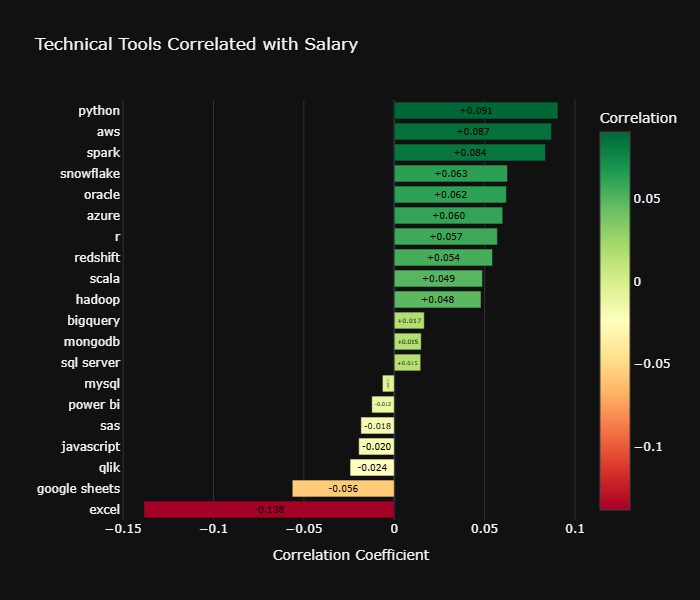

In [22]:
# Visualize top correlations - SOFTWARE/TOOLS ONLY
software_corr_df = corr_df[corr_df['category'] == 'Technical Tool']

top_n = 20
plot_df = pd.concat([
    software_corr_df.head(top_n//2),
    software_corr_df.tail(top_n//2)
]).sort_values('correlation')

fig = go.Figure(go.Bar(
    x=plot_df['correlation'],
    y=plot_df['skill'],
    orientation='h',
    marker=dict(
        color=plot_df['correlation'],
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title="Correlation")
    ),
    text=plot_df['correlation'].apply(lambda x: f'{x:+.3f}'),
    textposition='inside',
    textfont=dict(size=14, color='black'),  # Add this for uniform size and color
    insidetextanchor='middle'  # Centers the text in the bars
))

fig.update_layout(
    title='Technical Tools Correlated with Salary',
    xaxis_title='Correlation Coefficient',
    yaxis_title='',
    height=600,
    template='plotly_dark',
)
fig.show(renderer='png')

## 5. Experience Level vs Salary

In [71]:
# Experience level correlation
exp_corr, exp_p = pearsonr(df_analysis['experience_numeric'], df_analysis['salary_avg'])

print(f"\nExperience Level Correlation with Salary:")
print(f"Pearson r = {exp_corr:.3f} (p < 0.001)")
print(f"\nThis is {'STRONGER' if abs(exp_corr) > corr_df['correlation'].abs().max() else 'WEAKER'} than any individual skill")


Experience Level Correlation with Salary:
Pearson r = 0.332 (p < 0.001)

This is STRONGER than any individual skill


In [72]:
# Salary by experience level (Entry to Senior only)
exp_salary = df_analysis.groupby('experience_level')['salary_avg'].agg(['mean', 'median', 'count']).round(0)
exp_salary = exp_salary.reindex(['Entry', 'Mid', 'Senior'])

print("\nSalary by Experience Level:")
print("="*60)
print(exp_salary)


Salary by Experience Level:
                      mean    median  count
experience_level                           
Entry              83412.0   75119.0    298
Mid                91007.0   86239.0   8329
Senior            121688.0  119101.0   2339


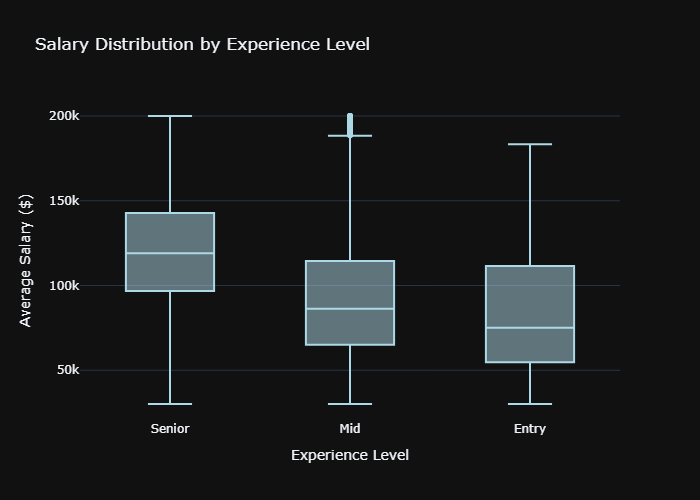

In [23]:
# Visualize experience vs salary
fig = px.box(
    df_analysis,
    x='experience_level',
    y='salary_avg',
    category_orders={'experience_level': ['Entry Level', 'Mid Level', 'Senior Level', 'Lead', 'Executive']},
    title='Salary Distribution by Experience Level',
    labels={'salary_avg': 'Average Salary ($)', 'experience_level': 'Experience Level'},
    template='plotly_dark'
)

fig.update_traces(marker=dict(color='lightblue'))
fig.show(renderer='png')

## 6. Partial Correlation (Controlling for Experience)

In [88]:
# Categorize skills into Software vs General Skills
software_skills = [
    'python', 'r', 'sql', 'sas', 'java', 'scala', 'javascript',
    'tableau', 'power bi', 'looker', 'qlik', 'excel', 'google sheets',
    'mongodb', 'oracle', 'snowflake', 'redshift', 'bigquery', 
    'mysql', 'postgresql', 'sql server',
    'aws', 'azure', 'gcp',
    'spark', 'hadoop', 'airflow', 'kafka', 'dbt', 'pandas', 'numpy', 'git' 
]

general_skills = [
    'statistics', 'machine learning', 'regression', 'a/b testing',
    'business intelligence', 'data visualization', 'etl', 
    'data warehouse', 'data modeling', 'agile', 'api'
]

# Separate correlations
software_corrs = partial_df[partial_df['skill'].isin(software_skills)].copy()
general_corrs = partial_df[partial_df['skill'].isin(general_skills)].copy()

print(f"Technical Skills: {len(software_corrs)} skills")
print(f"General Skills: {len(general_corrs)} skills")

Technical Skills: 32 skills
General Skills: 10 skills


In [90]:
print("\n" + "="*80)
print("TECHNICAL TOOLS - PARTIAL CORRELATION (Controlling for Experience)")
print(f"Analyzing {len(software_corrs)} software/tools, showing top 10")
print("="*80)

for idx, row in software_corrs.sort_values('partial_correlation', ascending=False).head(10).iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")


TECHNICAL TOOLS - PARTIAL CORRELATION (Controlling for Experience)
Analyzing 32 software/tools, showing top 10
python                    | Regular: +0.091 | Partial: +0.087 | Diff: +0.003
spark                     | Regular: +0.084 | Partial: +0.079 | Diff: +0.004
aws                       | Regular: +0.087 | Partial: +0.076 | Diff: +0.011
azure                     | Regular: +0.060 | Partial: +0.057 | Diff: +0.003
r                         | Regular: +0.057 | Partial: +0.048 | Diff: +0.009
redshift                  | Regular: +0.054 | Partial: +0.047 | Diff: +0.008
snowflake                 | Regular: +0.063 | Partial: +0.045 | Diff: +0.018
git                       | Regular: +0.043 | Partial: +0.042 | Diff: +0.001
airflow                   | Regular: +0.040 | Partial: +0.041 | Diff: -0.001
hadoop                    | Regular: +0.048 | Partial: +0.038 | Diff: +0.010


In [91]:
print("\n" + "="*80)
print("GENERAL SKILLS - PARTIAL CORRELATION (Controlling for Experience)")
print(f"Analyzing {len(general_corrs)} general skills, showing top 10")
print("="*80)

for idx, row in general_corrs.sort_values('partial_correlation', ascending=False).head(10).iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")


GENERAL SKILLS - PARTIAL CORRELATION (Controlling for Experience)
Analyzing 10 general skills, showing top 10
machine learning          | Regular: +0.105 | Partial: +0.099 | Diff: +0.006
etl                       | Regular: +0.072 | Partial: +0.055 | Diff: +0.017
regression                | Regular: +0.044 | Partial: +0.038 | Diff: +0.005
data warehouse            | Regular: +0.057 | Partial: +0.036 | Diff: +0.021
data modeling             | Regular: +0.042 | Partial: +0.036 | Diff: +0.007
agile                     | Regular: +0.037 | Partial: +0.025 | Diff: +0.012
business intelligence     | Regular: +0.040 | Partial: +0.020 | Diff: +0.019
api                       | Regular: +0.002 | Partial: +0.009 | Diff: -0.007
data visualization        | Regular: -0.002 | Partial: -0.003 | Diff: +0.001
statistics                | Regular: -0.015 | Partial: -0.023 | Diff: +0.007


In [ ]:
# Compare software vs general skills - HORIZONTAL (Technical on top)
top_software = software_corrs.sort_values('partial_correlation', ascending=False).head(10)
top_general = general_corrs.sort_values('partial_correlation', ascending=False)

# Sort ascending for bottom-to-top display
top_software = top_software.sort_values('partial_correlation', ascending=True)
top_general = top_general.sort_values('partial_correlation', ascending=True)

fig = go.Figure()

# Add General Skills FIRST (appears on bottom)
fig.add_trace(go.Bar(
    name='General Skills',
    y=top_general['skill'],
    x=top_general['partial_correlation'],
    orientation='h',
    marker_color='#FFC107'
))

# Add Technical Tools SECOND (appears on top)
fig.add_trace(go.Bar(
    name='Technical Tools',
    y=top_software['skill'],
    x=top_software['partial_correlation'],
    orientation='h',
    marker_color='#4CAF50'
))

fig.update_layout(
    title='Technical vs General Skills: Independent Effect on Salary<br><sub>Partial Correlation (Controlling for Experience)</sub>',
    xaxis_title='Partial Correlation',
    yaxis_title='',
    template='plotly_dark',
    height=600,
    barmode='group'
)

fig.show(renderer='png')

In [101]:
# Compare average effects
print("\n" + "="*80)
print("SOFTWARE vs GENERAL SKILLS COMPARISON")
print("="*80)

print(f"\nTechnical Tools (n={len(software_corrs)}):")
print(f"  Mean partial correlation: {software_corrs['partial_correlation'].mean():+.3f}")
print(f"  Strongest: {software_corrs.nlargest(1, 'partial_correlation').iloc[0]['skill']} "
      f"(r={software_corrs.nlargest(1, 'partial_correlation').iloc[0]['partial_correlation']:+.3f})")

print(f"\nGeneral Skills (n={len(general_corrs)}):")
print(f"  Mean partial correlation: {general_corrs['partial_correlation'].mean():+.3f}")
print(f"  Strongest: {general_corrs.nlargest(1, 'partial_correlation').iloc[0]['skill']} "
      f"(r={general_corrs.nlargest(1, 'partial_correlation').iloc[0]['partial_correlation']:+.3f})")

print(f"\n→ {'Technical Tools' if software_corrs['partial_correlation'].mean() > general_corrs['partial_correlation'].mean() else 'General Skills'} "
      f"have stronger independent effect on salary according to mean partial correlation values")


SOFTWARE vs GENERAL SKILLS COMPARISON

Technical Tools (n=32):
  Mean partial correlation: +0.020
  Strongest: python (r=+0.087)

General Skills (n=10):
  Mean partial correlation: +0.029
  Strongest: machine learning (r=+0.099)

→ General Skills have stronger independent effect on salary according to mean partial correlation values


In [103]:
# Calculate partial correlation for ALL skills (controlling for experience)
def partial_correlation(x, y, z):
    """Calculate partial correlation between x and y, controlling for z"""
    r_xy = np.corrcoef(x, y)[0, 1]
    r_xz = np.corrcoef(x, z)[0, 1]
    r_yz = np.corrcoef(y, z)[0, 1]
    
    numerator = r_xy - (r_xz * r_yz)
    denominator = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
    
    return numerator / denominator if denominator != 0 else 0

# Calculate partial correlations for all skills
partial_corrs = []

for idx, row in corr_df.iterrows():
    skill_col = f'skill_{row["skill"]}'
    
    # Regular correlation
    regular_corr = row['correlation']
    
    # Partial correlation (controlling for experience)
    partial_corr = partial_correlation(
        df_analysis[skill_col].values,
        df_analysis['salary_avg'].values,
        df_analysis['experience_numeric'].values
    )
    
    partial_corrs.append({
        'skill': row['skill'],
        'regular_correlation': regular_corr,
        'partial_correlation': partial_corr,
        'difference': regular_corr - partial_corr
    })

partial_df = pd.DataFrame(partial_corrs)

In [105]:
print("\n" + "="*80)
print("PARTIAL CORRELATION (Controlling for Experience Level)")
print("="*80)

print("\nTECHNICAL TOOLS with INDEPENDENT effect on salary:\n")
software_partial = partial_df[partial_df['skill'].isin(SOFTWARE_SKILLS)].sort_values('partial_correlation', ascending=False).head(10)
for idx, row in software_partial.iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")

print("\n" + "="*80)
print("\nGENERAL SKILLS with INDEPENDENT effect on salary:\n")
general_partial = partial_df[partial_df['skill'].isin(GENERAL_SKILLS)].sort_values('partial_correlation', ascending=False)
for idx, row in general_partial.iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")

print("\n" + "="*80)


PARTIAL CORRELATION (Controlling for Experience Level)

TECHNICAL TOOLS with INDEPENDENT effect on salary:

python                    | Regular: +0.091 | Partial: +0.087 | Diff: +0.003
spark                     | Regular: +0.084 | Partial: +0.079 | Diff: +0.004
aws                       | Regular: +0.087 | Partial: +0.076 | Diff: +0.011
azure                     | Regular: +0.060 | Partial: +0.057 | Diff: +0.003
r                         | Regular: +0.057 | Partial: +0.048 | Diff: +0.009
redshift                  | Regular: +0.054 | Partial: +0.047 | Diff: +0.008
snowflake                 | Regular: +0.063 | Partial: +0.045 | Diff: +0.018
git                       | Regular: +0.043 | Partial: +0.042 | Diff: +0.001
airflow                   | Regular: +0.040 | Partial: +0.041 | Diff: -0.001
hadoop                    | Regular: +0.048 | Partial: +0.038 | Diff: +0.010


GENERAL SKILLS with INDEPENDENT effect on salary:

machine learning          | Regular: +0.105 | Partial: +0.099 | Diff

## 8. Correlation Heatmap

In [116]:
# Create correlation matrix for top 10 technical + top 10 general skills ONLY
top_10_technical = corr_df[corr_df['category'] == 'Technical Tool'].head(10)['skill'].tolist()
top_10_general = corr_df[corr_df['category'] == 'General Skill'].head(10)['skill'].tolist()

all_top_skills = top_10_technical + top_10_general
skill_cols_subset = [f'skill_{s}' for s in all_top_skills]

# Correlation matrix of skills only
corr_matrix = df_analysis[skill_cols_subset].corr()

# Rename for readability
rename_dict = {f'skill_{s}': s for s in all_top_skills}
corr_matrix = corr_matrix.rename(columns=rename_dict, index=rename_dict)

print(f"Skill co-occurrence matrix:")
print(f"  - {len(top_10_technical)} technical tools")
print(f"  - {len(top_10_general)} general skills")

Skill co-occurrence matrix:
  - 10 technical tools
  - 10 general skills


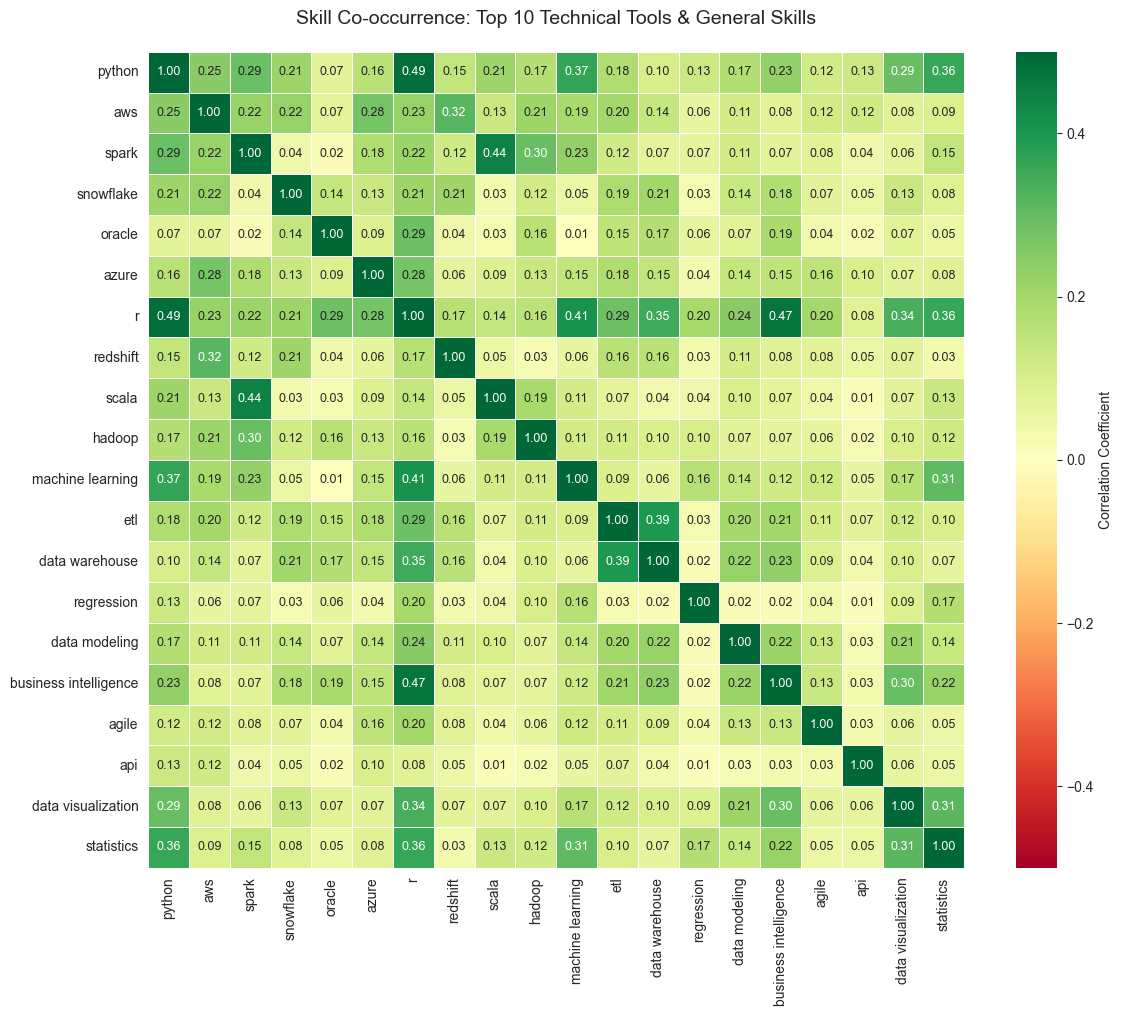


✓ Heatmap saved to C:\Users\Eilhart\Documents\PythonScripts\data-analyst-job-market\visualizations\correlation_heatmap.png


In [117]:
# Plot heatmap - CLEANER with top 10 of each
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    vmin=-0.5,
    vmax=0.5,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'},
    annot_kws={'size': 9}
)
plt.title('Skill Co-occurrence: Top 10 Technical Tools & General Skills', 
          fontsize=14, pad=20)
plt.tight_layout()

# Save using absolute path
import os
project_root = r'C:\Users\Eilhart\Documents\PythonScripts\data-analyst-job-market'
save_path = os.path.join(project_root, 'visualizations', 'correlation_heatmap.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Heatmap saved to {save_path}")

## 9. Key Findings Summary

In [111]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# 1. Strongest predictor
top_technical_corr = corr_df[corr_df['category'] == 'Technical Tool'].iloc[0]
top_general_corr = corr_df[corr_df['category'] == 'General Skill'].iloc[0]

print(f"\n1. STRONGEST SALARY PREDICTORS:")
print(f"   Experience Level:        r = {exp_corr:.3f}")
print(f"   Top Technical Tool ({top_technical_corr['skill']:12}): r = {top_technical_corr['correlation']:+.3f}")
print(f"   Top General Skill ({top_general_corr['skill']:12}): r = {top_general_corr['correlation']:+.3f}")
print(f"   → Experience is the STRONGEST predictor" if abs(exp_corr) > max(abs(top_technical_corr['correlation']), abs(top_general_corr['correlation'])) else "   → Skills can be as strong as experience")

# 2. Top value technical tools
print(f"\n2. TOP 5 HIGH-VALUE TECHNICAL TOOLS (sorted by correlation):")
for idx, row in corr_df[corr_df['category'] == 'Technical Tool'].head(5).iterrows():
    print(f"   {row['skill']:20} | r = {row['correlation']:+.3f} | "
          f"+${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%)")

# 2b. Top value general skills
print(f"\n3. TOP 5 HIGH-VALUE GENERAL SKILLS (sorted by correlation):")
for idx, row in corr_df[corr_df['category'] == 'General Skill'].head(5).iterrows():
    print(f"   {row['skill']:20} | r = {row['correlation']:+.3f} | "
          f"+${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%)")

# 3. Technical tools independent of experience
print(f"\n4. TECHNICAL TOOLS WITH INDEPENDENT EFFECT (after controlling for experience):")
for idx, row in partial_df[partial_df['skill'].isin(SOFTWARE_SKILLS)].nlargest(5, 'partial_correlation').iterrows():
    print(f"   {row['skill']:20} → Partial r = {row['partial_correlation']:+.3f}")

# 3b. General skills independent of experience
print(f"\n5. GENERAL SKILLS WITH INDEPENDENT EFFECT (after controlling for experience):")
for idx, row in partial_df[partial_df['skill'].isin(GENERAL_SKILLS)].nlargest(5, 'partial_correlation').iterrows():
    print(f"   {row['skill']:20} → Partial r = {row['partial_correlation']:+.3f}")

print("\n" + "="*80)


KEY FINDINGS

1. STRONGEST SALARY PREDICTORS:
   Experience Level:        r = 0.332
   Top Technical Tool (python      ): r = +0.091
   Top General Skill (machine learning): r = +0.105
   → Experience is the STRONGEST predictor

2. TOP 5 HIGH-VALUE TECHNICAL TOOLS (sorted by correlation):
   python               | r = +0.091 | +$  9,608 (+10.0%)
   aws                  | r = +0.087 | +$ 16,952 (+17.5%)
   spark                | r = +0.084 | +$ 22,453 (+23.2%)
   snowflake            | r = +0.063 | +$ 13,252 (+13.7%)
   oracle               | r = +0.062 | +$ 12,706 (+13.1%)

3. TOP 5 HIGH-VALUE GENERAL SKILLS (sorted by correlation):
   machine learning     | r = +0.105 | +$ 15,646 (+16.2%)
   etl                  | r = +0.072 | +$ 11,445 (+11.8%)
   data warehouse       | r = +0.057 | +$  9,815 (+10.1%)
   regression           | r = +0.044 | +$ 12,761 (+13.1%)
   data modeling        | r = +0.042 | +$  7,605 ( +7.8%)

4. TECHNICAL TOOLS WITH INDEPENDENT EFFECT (after controlling for e

## 10. Export Results

In [112]:
# Save correlation results
corr_df.to_csv('../data/processed/skill_salary_correlations.csv', index=False)
combo_df.to_csv('../data/processed/skill_combinations_analysis.csv', index=False)
partial_df.to_csv('../data/processed/partial_correlations.csv', index=False)

print("\n✓ Results exported to data/processed/")
print("  - skill_salary_correlations.csv")
print("  - skill_combinations_analysis.csv")
print("  - partial_correlations.csv")


✓ Results exported to data/processed/
  - skill_salary_correlations.csv
  - skill_combinations_analysis.csv
  - partial_correlations.csv
